# Jina Workshop @ EuroPython: Building a Neural Image Search Engine

In this workshop we will build a neural search engine for images of Pokemons.

# TABLE OF CONTENTS

...



# Downloading data and model

Skip this if you've already downloaded them.

## Download and Extract Data

For this example we're using Pokemon sprites from [veekun.com](https://veekun.com/dex/downloads). To download them run:

```sh
sh ./get_data.sh
```

## Download and Extract Pretrained Model

In this example we use [BiT (Big Transfer) model](https://github.com/google-research/big_transfer), To download it:

```sh
sh ./download.sh
```

# The problem

We want to search Pokemon by pictures! For example 

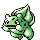

May return

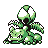 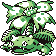

# Code

Automatically reload changed files when running code.

In [1]:
%load_ext autoreload
%autoreload 2

Remove (some) warnings from TF and Torch

In [2]:
import warnings
warnings.filterwarnings("ignore")

Required imports

In [3]:
import os
import sys
from shutil import rmtree
from glob import glob
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image

from jina import Flow, DocumentArray, Document

from jinahub.image.normalizer import ImageNormalizer
from jinahub.image.encoder.big_transfer import BigTransferEncoder
from jinahub.image.encoder.torch_encoder import ImageTorchEncoder

from components import MemMapIndexer

2021-07-09 12:25:54.534091: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-07-09 12:25:54.534131: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Some configuration options.

- restrict the nr of docs we index
- the path to the images

In [4]:
# TODO adapt nr of image. pre-index dataset before workshop
num_docs = int(os.environ.get('JINA_MAX_DOCS', 5))
image_src = 'data/**/*.png'

Environment variables

- workspace (folder where the encoded data will be stored)
- port we will listen on

In [5]:
workspace = './workspace'
os.environ['JINA_WORKSPACE'] = workspace
os.environ['JINA_PORT'] = os.environ.get('JINA_PORT', str(45678))

We need to make sure to not index on top of an existing workspace. 

This can cause problems if you are using different configuration options between the two runs.

In [6]:
if os.path.exists(workspace):
    print(f'Workspace at {workspace} exists. Will delete')
    rmtree(workspace)

# Flows

The Flow is the main pipeline in Jina. It describes the way data should be loaded, processed, stored etc. within the system. 

It is made up of components (called Executors), which are the ones doing the specific task.

Ex. we have a crafter Executor, which preprocesses the data; an Encoder Executor, which loads the model and *encodes* that data;  Indexer Executor, which stores and retrieves the data etc.

## Index

This is the Flow we use to perform operations on our data.

In [7]:
f = Flow.load_config('flows/flow.yml')

We can plot it.

In [8]:
f.plot('index.png')

The Flow is a context manager (like a file handler). Within the context, it starts all the Executors within their processes / threads.

We load data into the pipeline from the directory we provided above. 

`request_size` dictates how many images should be sent in one request (~batching).

In [9]:
def get_docs(image_src, num_docs):
    docs = DocumentArray()

    for file in glob(image_src, recursive=True):
        # Uniform Resource Identifier
        doc = Document(uri=file)
        doc.convert_image_uri_to_blob()
        doc.tags['filename'] = file
        docs.append(doc)
        if len(docs) == num_docs:
            break
            
    return docs

In [10]:
docs = get_docs(image_src, num_docs)

In [11]:
with f:
    f.post(
        on='/index',
        inputs=docs,
        request_size=64,
    )

        crafter@45812[L]:ready and listening
BigTransferEncoder@45846[W]:You tried to use a GPU but no GPU was found on your system. Defaulting to CPU!
BigTransferEncoder@45846[I]:BiT model path: pretrained


2021-07-09 12:25:57.089076: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-07-09 12:25:57.089117: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-07-09 12:25:57.089330: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (x1): /proc/driver/nvidia/version does not exist


2021-07-09 12:25:57.393400: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


        encoder@45812[L]:ready and listening
        indexer@45812[L]:ready and listening
        gateway@45812[L]:ready and listening
           Flow@45812[I]:🎉 Flow is ready to use!
	🔗 Protocol: 		GRPC
	🏠 Local access:	0.0.0.0:44069
	🔒 Private network:	192.168.178.144:44069
	🌐 Public address:	2001:16b8:46c7:e200:2608:d9f9:7d3d:a4f6:44069


2021-07-09 12:26:12.041769: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-09 12:26:12.123299: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2299965000 Hz


           JINA@45852[E]:all gateway tasks are cancelled
        gateway@45852[E]:Received message is empty.


# Questions?

---

## Searching

We load the first image in the dataset

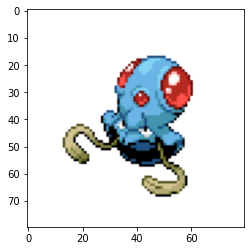

In [12]:
search_image = list(glob(image_src, recursive=True))[0]

# Let's plot the image

pil_im = Image.open(search_image)
imshow(pil_im)

We build a Document with that image

In [13]:
query_docs = get_docs(image_src, 1)

In [14]:
query_docs[0].tags

<jina.types.struct.StructView filename=data/pokemon/main-sprites/heartgold-soulsilver/72.png at 139856497267024>

In [15]:
with f:
    return_docs = f.post(
        on='/search',
        inputs=query_docs,
        parameters={'top_k': 5},
        return_results=True
    )

        crafter@45812[L]:ready and listening
BigTransferEncoder@45951[W]:You tried to use a GPU but no GPU was found on your system. Defaulting to CPU!
BigTransferEncoder@45951[I]:BiT model path: pretrained


2021-07-09 12:26:14.100390: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-07-09 12:26:14.100450: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-07-09 12:26:14.100485: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (x1): /proc/driver/nvidia/version does not exist


2021-07-09 12:26:14.412787: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


        encoder@45812[L]:ready and listening
        indexer@45812[L]:ready and listening
        gateway@45812[L]:ready and listening
           Flow@45812[I]:🎉 Flow is ready to use!
	🔗 Protocol: 		GRPC
	🏠 Local access:	0.0.0.0:46539
	🔒 Private network:	192.168.178.144:46539
	🌐 Public address:	2001:16b8:46c7:e200:2608:d9f9:7d3d:a4f6:46539


2021-07-09 12:26:30.084314: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-09 12:26:30.171352: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2299965000 Hz


           JINA@45957[E]:all gateway tasks are cancelled
        gateway@45957[E]:Received message is empty.


Retrieving tags (image path)

In [16]:
# top match is the same image
assert return_docs[0].docs[0].matches[0].tags['filename'] == return_docs[0].docs[0].tags['filename']

Reconstructing the original image from the Document content

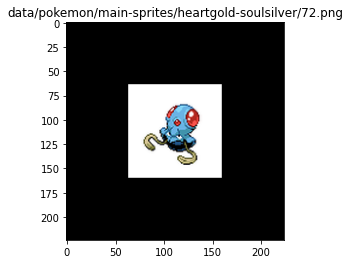

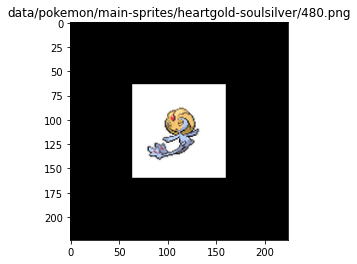

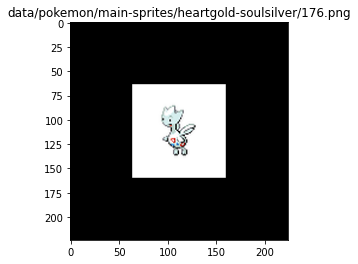

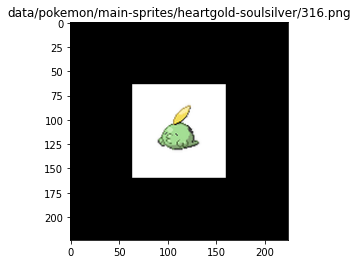

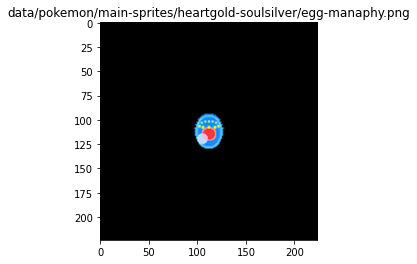

In [17]:
for match in return_docs[0].docs[0].matches:
    content = match.content*255
    img_array = content.astype(np.uint8)
    img = Image.fromarray(img_array)
    imshow(img)
    plt.title(match.tags['filename'])
    plt.show()

# Questions?

---

# Advanced Topics


**NOTE**: After configuring these, you will need to re-index your data and search again. 

## 1. Changing Encoders

We can switch the `Encoder` easily.

This is the component that is the actual **model**. This encodes the images into a vector space upon which you can perform cosine similarity (or other linear algebra operations).


`flows/flow.yml`:

```yaml
...
  - name: encoder
    timeout_ready: 600000
    uses:
        jtype: ImageTorchEncoder
        with:
          on_gpu: true
...
```

In [18]:
from jinahub.image.encoder.torch_encoder import ImageTorchEncoder

Now we re-run the cells above with the new Flow. Make sure to **delete the workspace**.

# Questions?

---

## 2. Your own custom Executor

Next let's delve one level deeper into Jina.

So far we have looked at the Flow (top level) and the Document (one element of data).

The intermediate level is the Executor (which is a component in the pipeline of the Flow).

Let's create an Executor which "logs" the query results.

OPTIONAL It's parallel.

OPTIONAL It's hanging.

# Questions?

---

## 3. Optimization

In every Flow that is build with Jina, there are quite some parameters to set.
For example, if you use a pre-trained model for encoding, there is no obvious best choice for a given dataset.
Jina allows you to try out a lot of different parameters automatically in order to get the best results.

Therefor, you need to provide Jina some sort of evaluation metric.
In the pokemon dataset, there are two edition with the same pokemon, but different images: `red-blue` and `red-green`.

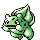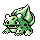

Thus, we will setup the following evaluation metric:
Index one edition and search with the other edition.
We have a success, if the right pokemon is at the first place in the search results.

We need to do the following steps:

- A) build an `index` and a `search` Flow, which are repeaditly runnable
- B) use the `red-blue` dataset for `index` and the `red-green` for `search`
- C) implement an `EvaluationCallback` which will calculate, if the right pokemon is in the first place
- D) set the needed `OptimizationParameter` via a `parameter.yml` file
- E) setup the optimization process itself

**NOTE**: Under the hood, we use [optuna](https://optuna.readthedocs.io/en/stable/) for hyperparameter optimization.

### Do the imports

In [19]:
from glob import iglob
from jina import Document
from jina.optimizers.flow_runner import SingleFlowRunner, MultiFlowRunner
from jina.optimizers import FlowOptimizer, EvaluationCallback

### A) & B)

Jina provides the 
- `SingleFlowRunner` for making a Flow repeaditly runnable and the 
- `MultiFlowRunner` to chain multiple `SingleFlowRunner` for the `FlowOptimizer`

For setup you need:
- `flow_yaml`: the definition of a Flow
- `documents`: the Documents, which are send to the Flow in each optimization step
- `execution_method`: tell the Flow, whether `index` or `search` should be used

Beware, that we introduce `JINA_MODEL_NAME_VAR: ${{JINA_MODEL_NAME}}` in the two new Flow definition.
This variable will allow us to change the model in the Flow in each optimization step.

In [20]:
def get_input_iterator(edition, full_document):
    image_src = f'data/pokemon/main-sprites/{edition}/*.png'
    for filename in iglob(image_src, recursive=True):
        doc = Document(uri=filename)
        doc.convert_image_uri_to_blob()

        doc.blob = doc.blob.astype(np.uint8)
        doc.tags['filename'] = filename
        yield doc

def get_flows():
    index_flow = SingleFlowRunner(
        flow_yaml='flows/flow_opt.yml',
        documents=get_input_iterator('red-blue', True),
        request_size=64,
        execution_endpoint='/index',
        overwrite_workspace=True
    )

    search_flow = SingleFlowRunner(
        flow_yaml='flows/flow_opt.yml',
        documents=get_input_iterator('red-green', False),
        request_size=64,
        execution_endpoint='/search'
    )

    multi_flow = MultiFlowRunner([index_flow, search_flow])
    return multi_flow


### C) implement an `EvaluationCallback` which will calculate, if the right pokemon is in the first place

Since the files are named the same for both editions, we use the filename as an identifier, whether we found the right pokemon.
The `PokemonCallback` checks for each Document, whether the correct result is in the first position.

In [21]:
def get_id(filename):
    return filename.split('/')[-1].split('.')[0]

class PokemonCallback(EvaluationCallback):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._eval_name = "pokedex_eval"

    def get_empty_copy(self):
        return PokemonCallback(self._eval_name)
    
    def __call__(self, response):
        self._n_docs += len(response.data.docs)
        for doc in response.data.docs:
            if doc.matches:
                document_id = get_id(str(doc.tags.fields['filename']))
                first_match_id = get_id(str(doc.matches[0].tags.fields['filename']))
                if document_id == first_match_id:
                    self._evaluation_values[self._eval_name].append(1)
                else:
                    self._evaluation_values[self._eval_name].append(0)
                    

### D) set the needed `OptimizationParameter` via a `parameter.yml` file

We defined in the `parameter_few.yml` the models, that the optimizer should try out.
For demonstation purpose, we just added three models, in order to make the optimizer run rather short.
If you want to try mode models, please use the `parameter.yml` file and increase `n_trials` parameter in the `FlowOptimizer` below

### E) setup the optimization process itself

Finally, we build the `FlowOptimizer` object.
It needs:
- `flow_runner`: the repeaditly runnable Flow object
- `parameter_yaml`: the parameters which the optimizer can change
- `evaluation_callback`: our previously defined evaluation function
- `workspace_base_dir`: A directory for temporary data
- `n_trials`: The amount of optimization steps, that should be performed
- `sampler`: the way, the `FlowOptimizer` should sample new values in each step. For more info please look at the [optuna docs](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.samplers.RandomSampler.html#optuna.samplers.RandomSampler).

In [22]:
def optimize(flows):
    optimizer = FlowOptimizer(
        flow_runner=flows,
        parameter_yaml='optimize/parameters_few.yml',
        evaluation_callback=PokemonCallback(eval_name='correct'),
        workspace_base_dir='workspace',
        n_trials=3,
        sampler='RandomSampler',
        # to guarantee reproducibility in the sampling
        seed=1
    )
    result = optimizer.optimize_flow()
    result.save_parameters('optimize/best_config.yml')

In [23]:
flows = get_flows()
optimize(flows)

[I 2021-07-09 12:26:33,470] A new study created in memory with name: no-name-5d243c08-7a12-4cc6-b31a-588fd15b7216


        encoder@45812[L]:ready and listening
  embedding_idx@45812[L]:ready and listening
        gateway@45812[L]:ready and listening
           Flow@45812[I]:🎉 Flow is ready to use!
	🔗 Protocol: 		GRPC
	🏠 Local access:	0.0.0.0:57877
	🔒 Private network:	192.168.178.144:57877
	🌐 Public address:	2001:16b8:46c7:e200:2608:d9f9:7d3d:a4f6:57877
           JINA@46224[E]:all gateway tasks are cancelled
        gateway@46224[E]:Received message is empty.
           JINA@45812[W]:Workspace workspace/JINA_WORKSPACE_alexnet already exists. Please set ``overwrite_workspace=True`` for replacing it.
        encoder@45812[L]:ready and listening
  embedding_idx@45812[L]:ready and listening
        gateway@45812[L]:ready and listening
           Flow@45812[I]:🎉 Flow is ready to use!
	🔗 Protocol: 		GRPC
	🏠 Local access:	0.0.0.0:39023
	🔒 Private network:	192.168.178.144:39023
	🌐 Public address:	2001:16b8:46c7:e200:2608:d9f9:7d3d:a4f6:39023
           JINA@46282[E]:all gateway tasks are cancelled
        

[I 2021-07-09 12:26:42,582] Trial 0 finished with value: 0.6821192052980133 and parameters: {'JINA_MODEL_NAME': 'alexnet'}. Best is trial 0 with value: 0.6821192052980133.


        encoder@45812[L]:ready and listening
  embedding_idx@45812[L]:ready and listening
        gateway@45812[L]:ready and listening
           Flow@45812[I]:🎉 Flow is ready to use!
	🔗 Protocol: 		GRPC
	🏠 Local access:	0.0.0.0:42753
	🔒 Private network:	192.168.178.144:42753
	🌐 Public address:	2001:16b8:46c7:e200:2608:d9f9:7d3d:a4f6:42753
           JINA@46358[E]:all gateway tasks are cancelled
        gateway@46358[E]:Received message is empty.
           JINA@45812[W]:Workspace workspace/JINA_WORKSPACE_resnet18 already exists. Please set ``overwrite_workspace=True`` for replacing it.
        encoder@45812[L]:ready and listening
  embedding_idx@45812[L]:ready and listening
        gateway@45812[L]:ready and listening
           Flow@45812[I]:🎉 Flow is ready to use!
	🔗 Protocol: 		GRPC
	🏠 Local access:	0.0.0.0:53131
	🔒 Private network:	192.168.178.144:53131
	🌐 Public address:	2001:16b8:46c7:e200:2608:d9f9:7d3d:a4f6:53131
           JINA@46501[E]:all gateway tasks are cancelled
       

[I 2021-07-09 12:26:57,606] Trial 1 finished with value: 0.5960264900662252 and parameters: {'JINA_MODEL_NAME': 'resnet18'}. Best is trial 0 with value: 0.6821192052980133.


        encoder@45812[L]:ready and listening
  embedding_idx@45812[L]:ready and listening
        gateway@45812[L]:ready and listening
           Flow@45812[I]:🎉 Flow is ready to use!
	🔗 Protocol: 		GRPC
	🏠 Local access:	0.0.0.0:57477
	🔒 Private network:	192.168.178.144:57477
	🌐 Public address:	2001:16b8:46c7:e200:2608:d9f9:7d3d:a4f6:57477
           JINA@46819[E]:all gateway tasks are cancelled
        gateway@46819[E]:Received message is empty.
           JINA@45812[W]:Workspace workspace/JINA_WORKSPACE_squeezenet1_0 already exists. Please set ``overwrite_workspace=True`` for replacing it.
        encoder@45812[L]:ready and listening
  embedding_idx@45812[L]:ready and listening
        gateway@45812[L]:ready and listening
           Flow@45812[I]:🎉 Flow is ready to use!
	🔗 Protocol: 		GRPC
	🏠 Local access:	0.0.0.0:36857
	🔒 Private network:	192.168.178.144:36857
	🌐 Public address:	2001:16b8:46c7:e200:2608:d9f9:7d3d:a4f6:36857
           JINA@46944[E]:all gateway tasks are cancelled
  

[I 2021-07-09 12:27:07,786] Trial 2 finished with value: 0.7748344370860927 and parameters: {'JINA_MODEL_NAME': 'squeezenet1_0'}. Best is trial 2 with value: 0.7748344370860927.


           JINA@45812[I]:Number of finished trials: 3
           JINA@45812[I]:Best trial: {'JINA_MODEL_NAME': 'squeezenet1_0'}
           JINA@45812[I]:Time to finish: 0:00:10.174707


We can now check `optimize/best_config.yml` to see our best configuration.